In [1]:
import os
import time
import sys
from pathlib import Path
import torch
import numpy as np
import psdr_jit as psdr
import drjit
from drjit.cuda.ad import Int as IntD, Float as FloatD, Matrix4f as Matrix4fD, Array3f as Vector3fD, Array2f as Vector2fD
from drjit.cuda import Float as FloatC, Matrix4f as Matrix4fC, Array3f as Vector3fC
from drjit.cuda import PCG32 as PCG32C, UInt64 as UInt64C
from image_util import *
import matplotlib.pyplot as plt
from PIL import Image
from embedder import *
from torch import nn
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2


In [2]:
fembed, embed_dim = get_embedder(10, 2)
print("embed_dim", embed_dim)
layer_size = 64
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(embed_dim, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, 3),
          nn.Sigmoid()
        ).cuda()
    def forward(self, x):
        return self.layers(x)

embed_dim 42


In [3]:
mlp_image = MLP()
x = np.linspace(0, 1, 512)
y = np.linspace(0, 1, 512)
debug_color = torch.tensor(np.meshgrid(x, y), dtype=torch.float32).cuda()
debug_color = (torch.transpose(debug_color.reshape(2, -1), 0, 1))
data_in = fembed(debug_color)
opt_map = mlp_image(data_in)



<ipython-input-3-ebf1f8f49f0e>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  debug_color = torch.tensor(np.meshgrid(x, y), dtype=torch.float32).cuda()


In [4]:
target_img = cv2.imread("./data/texture/illya.exr", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
target_img = cv2.cvtColor(target_img, cv2.COLOR_RGB2BGR)
target_img = torch.tensor(target_img, device='cuda', dtype=torch.float32)

it: 0 loss 0.23190581798553467


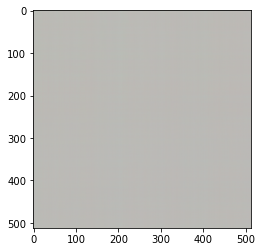

it: 100 loss 0.10061077773571014


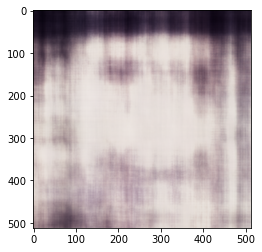

it: 200 loss 0.05751494690775871


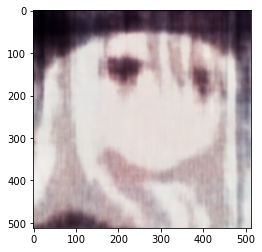

In [5]:
# train a network
optimizer = torch.optim.Adam(mlp_image.parameters(), lr=1e-3)
num_iter = 200
for it in range(num_iter+1):
    optimizer.zero_grad()
    opt_map = mlp_image(data_in)#.reshape((512, 512, 3))
    loss = (target_img.reshape((-1, 3))-opt_map).abs().mean()
    loss.backward()
    optimizer.step()

    if it % 100 == 0:
        print("it:", it, "loss", loss.item())
        img = to_srgb(opt_map.detach().cpu().numpy().reshape((512, 512, 3)))
        imgplot = plt.imshow(img)
        plt.show()

In [6]:
class MyColorBSDF(psdr.BSDF):
    def __init__(self, mlp_data):
        psdr.BSDF.__init__(self)
        self.mlp_data = mlp_data

    def anisotropic(self):
        return False

    def to_string(self):
        return "MyColorBSDF[id=" + self.id + "]"

    def eval(self, its, wo, active):
        mlp_texture = self.mlp_data(fembed(its.uv.torch()))
        return Vector3fD(mlp_texture) & active


In [7]:
class SimpleIntegrator():
    def __init__(self, spp, width, height):
        self.width = width
        self.height = height
        self.num_pixels = self.width*self.height
        self.spp = spp
        self.sampler = psdr.Sampler()
        if self.spp > 0:
            self.sampler.seed(drjit.arange(UInt64C, self.spp*self.num_pixels))

    def Li(self, scene, ray, valid=True):
        ray = psdr.Ray(ray.o, ray.d)
        its = scene.ray_intersectAD(ray, valid)
        value = scene.mesh[0].bsdf.eval(its, its.wi, valid)
        value[drjit.isnan(value)] = 0.
        value[drjit.isinf(value)] = 0.
        return value

    def render(self, scene, sensor_id):
        result = self.render_spp(scene, sensor_id)
        return result

    def render_spp(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.spp == 0:
            return result
        with drjit.suspend_grad():
            idx = drjit.arange(IntD, self.num_pixels)
            num_samples = self.num_pixels * self.spp
            idx = drjit.arange(IntD, num_samples)
            idx = idx // self.spp
            dx, dy = drjit.meshgrid(drjit.arange(FloatD, self.width), drjit.arange(FloatD, self.height))
            samples_base = drjit.gather(Vector2fD, Vector2fD(dx, dy), idx)
            samples = (samples_base + self.sampler.next_2d())/Vector2fD(self.width, self.height);
            ray = scene.sensor[sensor_id].sample_primary_ray(samples);
        with drjit.resume_grad():
            value = self.Li(scene, ray)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, idx)
            result /= self.spp
        return result

In [8]:
sc = psdr.Scene()

sc.opts.spp = 8
sc.opts.sppe = 0
sc.opts.sppse = 0 
sc.opts.width = 512 
sc.opts.height = 512 
sc.opts.log_level = 0

In [9]:
sensor = psdr.PerspectiveCamera(30, 0.000001, 10000000.)
to_world = Matrix4fD([[1.,0.,0.,0.],
                     [0.,0.,-1.,5.],
                     [0.,1.,0.,0.],
                     [0.,0.,0.,1.],])
sensor.to_world = to_world
sc.add_Sensor(sensor)

In [10]:
mybsdf = MyColorBSDF(mlp_image)
sc.add_BSDF(mybsdf, "illya")
sc.add_Mesh("./data/uv_plane.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "illya", None, True)
sc.configure()

In [11]:
integrator = SimpleIntegrator(sc.opts.spp, sc.opts.height, sc.opts.width)

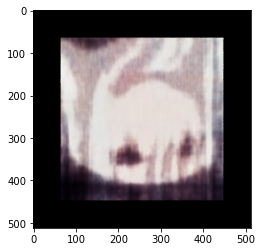

In [12]:
img_target = integrator.render(sc, 0)
img = img_target.numpy().reshape((sc.opts.width, sc.opts.height, 3))
img = to_srgb(np.asarray(img))
imgplot = plt.imshow(img)
